## experiment tracking
* **Tools** used to track Experiment `tensorbord` , `Weights And Biases` , `MLflow`
* What kind  of experiment tracking should we do? you should always start less and get great base line then you can scale up 
> change number of **epochs** **hiddenlayers** **data batch size , augumentation**, **learningrate** , **architecture** so on and so forth

| **Method** | **Setup** | **Pros** | **Cons** | **Cost** |
| ----- | ----- | ----- | ----- | ----- |
| Python dictionaries, CSV files, print outs | None | Easy to setup, runs in pure Python | Hard to keep track of large numbers of experiments | Free |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) | Minimal, install [`tensorboard`](https://pypi.org/project/tensorboard/) | Extensions built into PyTorch, widely recognized and used, easily scales. | User-experience not as nice as other options. | Free |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Minimal, install [`wandb`](https://docs.wandb.ai/quickstart), make an account | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch. | Free for personal use | 
| [MLFlow](https://mlflow.org/) | Minimal, install `mlflow` and start tracking | Fully open-source MLOps lifecycle management, many integrations. | Little bit harder to setup a remote tracking server than other services. | Free | 


In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
torch version: 2.7.1
torchvision version: 0.22.1


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

/Users/bhushanchowdary/Documents/GitHub/PyTorch_fundamentals/torch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

In [4]:
# seting up our seed 
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)

## looking up the data path

In [6]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [7]:
## setting up the train and test path  and data loaders
train_dir = image_path / "train"
test_dir = image_path / "test"
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
manual_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    normalize
])
train_dataloader ,test_dataloader , class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32,
)
train_dataloader , test_dataloader , class_names 

(<torch.utils.data.dataloader.DataLoader at 0x1123cc400>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# now what are we doing is auto matic transform
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
automatic_transforms = weights.transforms()
train_dataloader , test_dataloader , class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32,
)
train_dataloader , test_dataloader , class_names

(<torch.utils.data.dataloader.DataLoader at 0x1121243a0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# now converting the classfier head to give use outputfeatures as many as our classes
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model.parameters():
    param.requires_grad = False

set_seed()

model.classifier[1] = nn.Linear(in_features=1280, out_features=len(class_names)).to(device)

In [10]:
from torchinfo import summary
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter()

* nowwe are goint set up our final peice wihc is tensorborad
* `writer` -> `writer.add_scaler(main_tag , tag_scalar_dict)` 
* `main_tag`_> the one thats being tracked and `tag_scalar`-> values dictionary 

In [14]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

In [15]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

In [19]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader : torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 3,
          device: torch.device = device) -> Dict[str, List[float]]:
    """
    Trains a PyTorch model using a training and test dataloader.
    """

    # Move model to device
    model.to(device)

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs), desc="Training epochs"):
        print(f"Epoch: {epoch+1}/{epochs}")
        model.train()
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

        model.eval()
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Log to TensorBoard
        writer.add_scalars("Loss", {
            "train": train_loss,
            "test": test_loss
        }, global_step=epoch)

        writer.add_scalars("Accuracy", {
            "train": train_acc,
            "test": test_acc
        }, global_step=epoch)

        # Avoid logging large graph every epoch (optional)
        if epoch == 0:
            writer.add_graph(model=model,
                             input_to_model=torch.randn(32, 3, 224, 224).to(device),
                             verbose=False)

    writer.close()
    return results


In [20]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seed()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

Training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Train loss: 1.08153 | Train accuracy: 0.40%
Test loss: 0.89852 | Test accuracy: 0.59%


Training epochs:  20%|██        | 1/5 [01:02<04:09, 62.28s/it]

Epoch: 2/5
Train loss: 0.92067 | Train accuracy: 0.66%


Training epochs:  40%|████      | 2/5 [02:02<03:03, 61.14s/it]

Test loss: 0.79619 | Test accuracy: 0.85%
Epoch: 3/5
Train loss: 0.80259 | Train accuracy: 0.73%


Training epochs:  60%|██████    | 3/5 [03:02<02:01, 60.65s/it]

Test loss: 0.67906 | Test accuracy: 0.88%
Epoch: 4/5
Train loss: 0.68600 | Train accuracy: 0.88%


Training epochs:  80%|████████  | 4/5 [04:02<01:00, 60.45s/it]

Test loss: 0.65684 | Test accuracy: 0.91%
Epoch: 5/5
Train loss: 0.64424 | Train accuracy: 0.88%


Training epochs: 100%|██████████| 5/5 [05:02<00:00, 60.59s/it]

Test loss: 0.64058 | Test accuracy: 0.85%


In [21]:
results

{'train_loss': [1.0815254300832748,
  0.9206662699580193,
  0.8025866597890854,
  0.6860017403960228,
  0.6442410424351692],
 'train_acc': [0.40234375, 0.66015625, 0.734375, 0.8828125, 0.8828125],
 'test_loss': [0.8985207478205363,
  0.796194314956665,
  0.6790639162063599,
  0.6568403045336405,
  0.6405788461367289],
 'test_acc': [0.5909090909090909,
  0.8456439393939394,
  0.8759469696969697,
  0.9071969696969697,
  0.8456439393939394]}

In [22]:
torch.utils.tensorboard

<module 'torch.utils.tensorboard' from '/Users/bhushanchowdary/Documents/GitHub/PyTorch_fundamentals/torch-env/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py'>

In [24]:
# Line magic to load TensorBoard
%load_ext tensorboard


In [25]:
%tensorboard --logdir runs


![Screenshot 2025-06-27 at 10.39.51 AM.png](<attachment:Screenshot 2025-06-27 at 10.39.51 AM.png>)
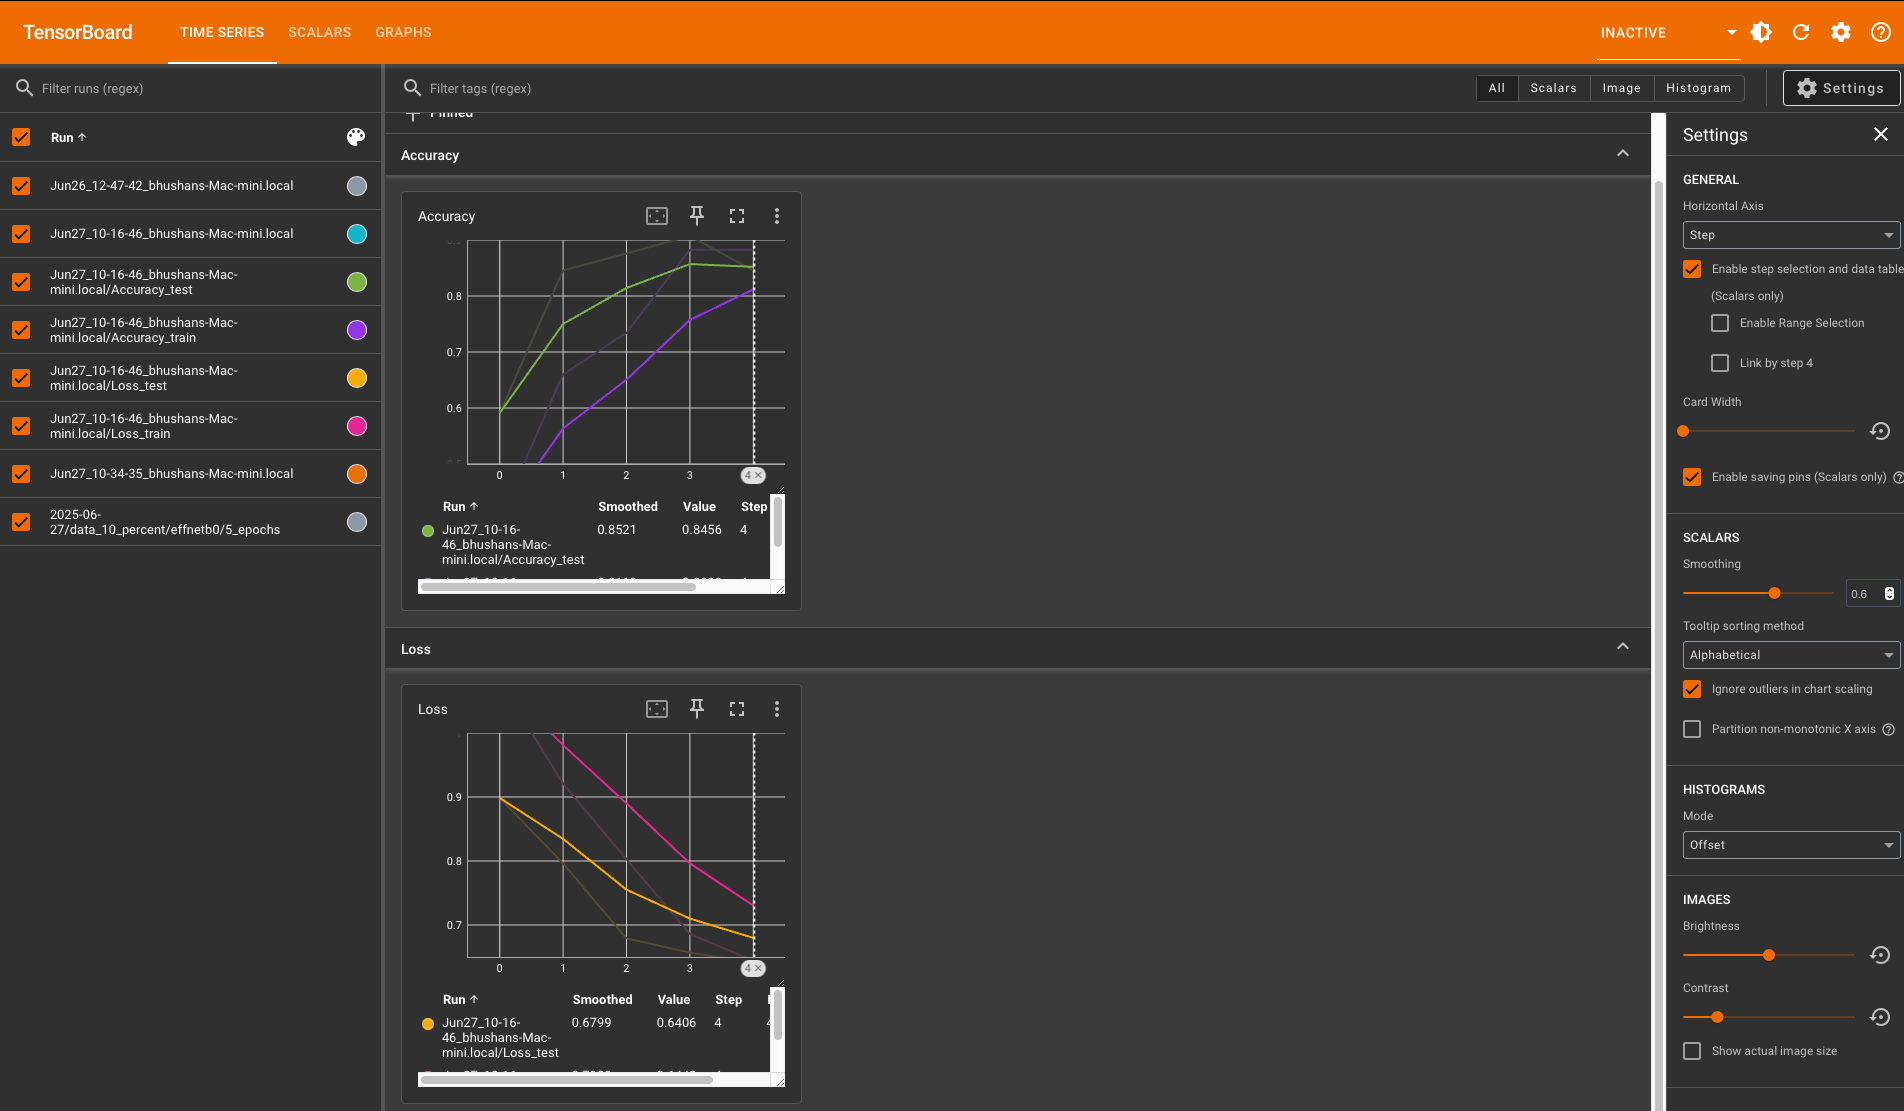

In [26]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [27]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_10_percent/effnetb0/5_epochs...


### setting up the series of modeling experiments


| Experiment number | Training Dataset | Model (pretrained on ImageNet) | Number of epochs |
| ----- | ----- | ----- | ----- |
| 1 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 5 |
| 2 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 5 | 
| 3 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 10 | 
| 4 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 10 |
| 5 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 5 |
| 6 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 5 |
| 7 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 10 |
| 8 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 10 |


In [28]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [29]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [30]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [31]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [32]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/bhushanchowdary/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 40.5MB/s]


Number of in_features to final layer of EfficientNetB2: 1408


In [37]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seed()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seed()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [38]:
effnetb0 = create_effnetb0() 

[INFO] Created new effnetb0 model.


In [39]:
effnetb2 = create_effnetb2()


[INFO] Created new effnetb2 model.


In [40]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [43]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [44]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seed(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/bhushanchowdary/Documents/GitHub/PyTorch_fundamentals/torch-env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 20%|██        | 1/5 [01:00<04:03, 60.89s/it]

Epoch: 1 | train_loss: 1.0624 | train_acc: 0.4648 | test_loss: 0.9344 | test_acc: 0.4574


 40%|████      | 2/5 [02:01<03:02, 60.80s/it]

Epoch: 2 | train_loss: 0.8662 | train_acc: 0.6445 | test_loss: 0.8218 | test_acc: 0.6004


 60%|██████    | 3/5 [03:01<02:00, 60.45s/it]

Epoch: 3 | train_loss: 0.8138 | train_acc: 0.6680 | test_loss: 0.7122 | test_acc: 0.8665


 80%|████████  | 4/5 [04:02<01:00, 60.43s/it]

Epoch: 4 | train_loss: 0.7043 | train_acc: 0.7539 | test_loss: 0.5845 | test_acc: 0.8864


100%|██████████| 5/5 [05:02<00:00, 60.50s/it]

Epoch: 5 | train_loss: 0.6245 | train_acc: 0.9023 | test_loss: 0.5554 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_10_percent/effnetb2/5_epochs...


 20%|██        | 1/5 [01:02<04:10, 62.66s/it]

Epoch: 1 | train_loss: 1.0818 | train_acc: 0.3594 | test_loss: 0.9402 | test_acc: 0.7320


 40%|████      | 2/5 [02:03<03:05, 61.84s/it]

Epoch: 2 | train_loss: 0.9290 | train_acc: 0.6211 | test_loss: 0.8590 | test_acc: 0.8144


 60%|██████    | 3/5 [03:04<02:02, 61.37s/it]

Epoch: 3 | train_loss: 0.8210 | train_acc: 0.7227 | test_loss: 0.7460 | test_acc: 0.9280


 80%|████████  | 4/5 [04:06<01:01, 61.34s/it]

Epoch: 4 | train_loss: 0.7035 | train_acc: 0.8711 | test_loss: 0.7144 | test_acc: 0.9280


100%|██████████| 5/5 [05:07<00:00, 61.47s/it]

Epoch: 5 | train_loss: 0.6543 | train_acc: 0.7852 | test_loss: 0.6996 | test_acc: 0.8769
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth


--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_10_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [01:01<09:12, 61.36s/it]

Epoch: 1 | train_loss: 1.0624 | train_acc: 0.4648 | test_loss: 0.9344 | test_acc: 0.4574


 20%|██        | 2/10 [02:02<08:10, 61.28s/it]

Epoch: 2 | train_loss: 0.8662 | train_acc: 0.6445 | test_loss: 0.8218 | test_acc: 0.6004


 30%|███       | 3/10 [03:03<07:06, 60.94s/it]

Epoch: 3 | train_loss: 0.8138 | train_acc: 0.6680 | test_loss: 0.7122 | test_acc: 0.8665


 40%|████      | 4/10 [04:04<06:06, 61.12s/it]

Epoch: 4 | train_loss: 0.7043 | train_acc: 0.7539 | test_loss: 0.5845 | test_acc: 0.8864


 50%|█████     | 5/10 [05:05<05:05, 61.07s/it]

Epoch: 5 | train_loss: 0.6245 | train_acc: 0.9023 | test_loss: 0.5554 | test_acc: 0.8968


 60%|██████    | 6/10 [06:05<04:03, 60.85s/it]

Epoch: 6 | train_loss: 0.5406 | train_acc: 0.9102 | test_loss: 0.5867 | test_acc: 0.8759


 70%|███████   | 7/10 [07:07<03:03, 61.00s/it]

Epoch: 7 | train_loss: 0.5717 | train_acc: 0.7930 | test_loss: 0.5365 | test_acc: 0.8864


 80%|████████  | 8/10 [08:08<02:01, 60.96s/it]

Epoch: 8 | train_loss: 0.4820 | train_acc: 0.9297 | test_loss: 0.4970 | test_acc: 0.8968


 90%|█████████ | 9/10 [09:09<01:01, 61.03s/it]

Epoch: 9 | train_loss: 0.6169 | train_acc: 0.7422 | test_loss: 0.4877 | test_acc: 0.9176


100%|██████████| 10/10 [10:09<00:00, 60.96s/it]

Epoch: 10 | train_loss: 0.4570 | train_acc: 0.9219 | test_loss: 0.4432 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_10_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [01:01<09:12, 61.35s/it]

Epoch: 1 | train_loss: 1.0818 | train_acc: 0.3594 | test_loss: 0.9402 | test_acc: 0.7320


 20%|██        | 2/10 [02:02<08:11, 61.47s/it]

Epoch: 2 | train_loss: 0.9290 | train_acc: 0.6211 | test_loss: 0.8590 | test_acc: 0.8144


 30%|███       | 3/10 [03:04<07:09, 61.36s/it]

Epoch: 3 | train_loss: 0.8210 | train_acc: 0.7227 | test_loss: 0.7460 | test_acc: 0.9280


 40%|████      | 4/10 [04:05<06:08, 61.34s/it]

Epoch: 4 | train_loss: 0.7035 | train_acc: 0.8711 | test_loss: 0.7144 | test_acc: 0.9280


 50%|█████     | 5/10 [05:06<05:06, 61.28s/it]

Epoch: 5 | train_loss: 0.6543 | train_acc: 0.7852 | test_loss: 0.6996 | test_acc: 0.8769


 60%|██████    | 6/10 [06:08<04:05, 61.36s/it]

Epoch: 6 | train_loss: 0.6050 | train_acc: 0.7969 | test_loss: 0.6287 | test_acc: 0.9176


 70%|███████   | 7/10 [07:09<03:04, 61.46s/it]

Epoch: 7 | train_loss: 0.5783 | train_acc: 0.8008 | test_loss: 0.6234 | test_acc: 0.8665


 80%|████████  | 8/10 [08:12<02:03, 61.72s/it]

Epoch: 8 | train_loss: 0.5221 | train_acc: 0.9219 | test_loss: 0.6108 | test_acc: 0.8873


 90%|█████████ | 9/10 [09:13<01:01, 61.67s/it]

Epoch: 9 | train_loss: 0.5202 | train_acc: 0.8086 | test_loss: 0.5986 | test_acc: 0.8977


100%|██████████| 10/10 [10:15<00:00, 61.50s/it]

Epoch: 10 | train_loss: 0.4647 | train_acc: 0.9258 | test_loss: 0.5687 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth


--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_20_percent/effnetb0/5_epochs...


 20%|██        | 1/5 [01:12<04:51, 72.84s/it]

Epoch: 1 | train_loss: 0.9505 | train_acc: 0.6167 | test_loss: 0.6602 | test_acc: 0.8655


 40%|████      | 2/5 [02:24<03:36, 72.04s/it]

Epoch: 2 | train_loss: 0.7002 | train_acc: 0.8104 | test_loss: 0.5948 | test_acc: 0.8873


 60%|██████    | 3/5 [03:35<02:23, 71.79s/it]

Epoch: 3 | train_loss: 0.5689 | train_acc: 0.8500 | test_loss: 0.4596 | test_acc: 0.9176


 80%|████████  | 4/5 [04:47<01:11, 71.61s/it]

Epoch: 4 | train_loss: 0.4909 | train_acc: 0.8542 | test_loss: 0.4386 | test_acc: 0.9280


100%|██████████| 5/5 [05:58<00:00, 71.74s/it]

Epoch: 5 | train_loss: 0.4904 | train_acc: 0.8396 | test_loss: 0.3942 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_20_percent/effnetb2/5_epochs...


 20%|██        | 1/5 [01:13<04:53, 73.29s/it]

Epoch: 1 | train_loss: 0.9844 | train_acc: 0.5292 | test_loss: 0.7837 | test_acc: 0.8153


 40%|████      | 2/5 [02:26<03:40, 73.34s/it]

Epoch: 2 | train_loss: 0.7533 | train_acc: 0.7729 | test_loss: 0.6677 | test_acc: 0.9072


 60%|██████    | 3/5 [03:39<02:26, 73.15s/it]

Epoch: 3 | train_loss: 0.6078 | train_acc: 0.8417 | test_loss: 0.5655 | test_acc: 0.9280


 80%|████████  | 4/5 [04:52<01:12, 72.88s/it]

Epoch: 4 | train_loss: 0.5370 | train_acc: 0.8667 | test_loss: 0.5733 | test_acc: 0.9280


100%|██████████| 5/5 [06:05<00:00, 73.17s/it]

Epoch: 5 | train_loss: 0.4497 | train_acc: 0.9000 | test_loss: 0.4585 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_20_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [02:56<26:31, 176.88s/it]

Epoch: 1 | train_loss: 0.9505 | train_acc: 0.6167 | test_loss: 0.6602 | test_acc: 0.8655


 20%|██        | 2/10 [04:08<15:18, 114.83s/it]

Epoch: 2 | train_loss: 0.7002 | train_acc: 0.8104 | test_loss: 0.5948 | test_acc: 0.8873


 30%|███       | 3/10 [05:19<11:04, 94.92s/it] 

Epoch: 3 | train_loss: 0.5689 | train_acc: 0.8500 | test_loss: 0.4596 | test_acc: 0.9176


 40%|████      | 4/10 [06:30<08:33, 85.53s/it]

Epoch: 4 | train_loss: 0.4909 | train_acc: 0.8542 | test_loss: 0.4386 | test_acc: 0.9280


 50%|█████     | 5/10 [07:42<06:43, 80.63s/it]

Epoch: 5 | train_loss: 0.4904 | train_acc: 0.8396 | test_loss: 0.3942 | test_acc: 0.9072


 60%|██████    | 6/10 [08:54<05:10, 77.65s/it]

Epoch: 6 | train_loss: 0.3848 | train_acc: 0.9125 | test_loss: 0.3680 | test_acc: 0.9280


 70%|███████   | 7/10 [10:06<03:47, 75.74s/it]

Epoch: 7 | train_loss: 0.3859 | train_acc: 0.8750 | test_loss: 0.3289 | test_acc: 0.9176


 80%|████████  | 8/10 [11:18<02:29, 74.70s/it]

Epoch: 8 | train_loss: 0.3775 | train_acc: 0.8854 | test_loss: 0.3371 | test_acc: 0.9384


 90%|█████████ | 9/10 [12:30<01:13, 73.83s/it]

Epoch: 9 | train_loss: 0.3240 | train_acc: 0.9292 | test_loss: 0.3158 | test_acc: 0.9176


100%|██████████| 10/10 [13:42<00:00, 82.22s/it]

Epoch: 10 | train_loss: 0.3607 | train_acc: 0.8875 | test_loss: 0.2811 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-06-27/data_20_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [01:13<10:58, 73.14s/it]

Epoch: 1 | train_loss: 0.9844 | train_acc: 0.5292 | test_loss: 0.7837 | test_acc: 0.8153


 20%|██        | 2/10 [02:24<09:38, 72.37s/it]

Epoch: 2 | train_loss: 0.7533 | train_acc: 0.7729 | test_loss: 0.6677 | test_acc: 0.9072


 30%|███       | 3/10 [03:36<08:24, 72.01s/it]

Epoch: 3 | train_loss: 0.6078 | train_acc: 0.8417 | test_loss: 0.5655 | test_acc: 0.9280


 40%|████      | 4/10 [04:48<07:12, 72.04s/it]

Epoch: 4 | train_loss: 0.5370 | train_acc: 0.8667 | test_loss: 0.5733 | test_acc: 0.9280


 50%|█████     | 5/10 [06:01<06:01, 72.24s/it]

Epoch: 5 | train_loss: 0.4497 | train_acc: 0.9000 | test_loss: 0.4585 | test_acc: 0.9176


 60%|██████    | 6/10 [07:13<04:48, 72.20s/it]

Epoch: 6 | train_loss: 0.3950 | train_acc: 0.9104 | test_loss: 0.4680 | test_acc: 0.9176


 70%|███████   | 7/10 [08:25<03:36, 72.24s/it]

Epoch: 7 | train_loss: 0.3627 | train_acc: 0.9250 | test_loss: 0.4185 | test_acc: 0.9384


 80%|████████  | 8/10 [09:38<02:24, 72.32s/it]

Epoch: 8 | train_loss: 0.3658 | train_acc: 0.9083 | test_loss: 0.4320 | test_acc: 0.8873


 90%|█████████ | 9/10 [10:51<01:12, 72.56s/it]

Epoch: 9 | train_loss: 0.3073 | train_acc: 0.9250 | test_loss: 0.4194 | test_acc: 0.8977


100%|██████████| 10/10 [12:04<00:00, 72.41s/it]

Epoch: 10 | train_loss: 0.3548 | train_acc: 0.9021 | test_loss: 0.3937 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------



CPU times: user 29.4 s, sys: 41.5 s, total: 1min 10s
Wall time: 1h 8min 28s


![Screenshot 2025-06-27 at 12.46.09 PM.png](<attachment:Screenshot 2025-06-27 at 12.46.09 PM.png>)
![Screenshot 2025-06-27 at 12.46.41 PM.png](<attachment:Screenshot 2025-06-27 at 12.46.41 PM.png>)
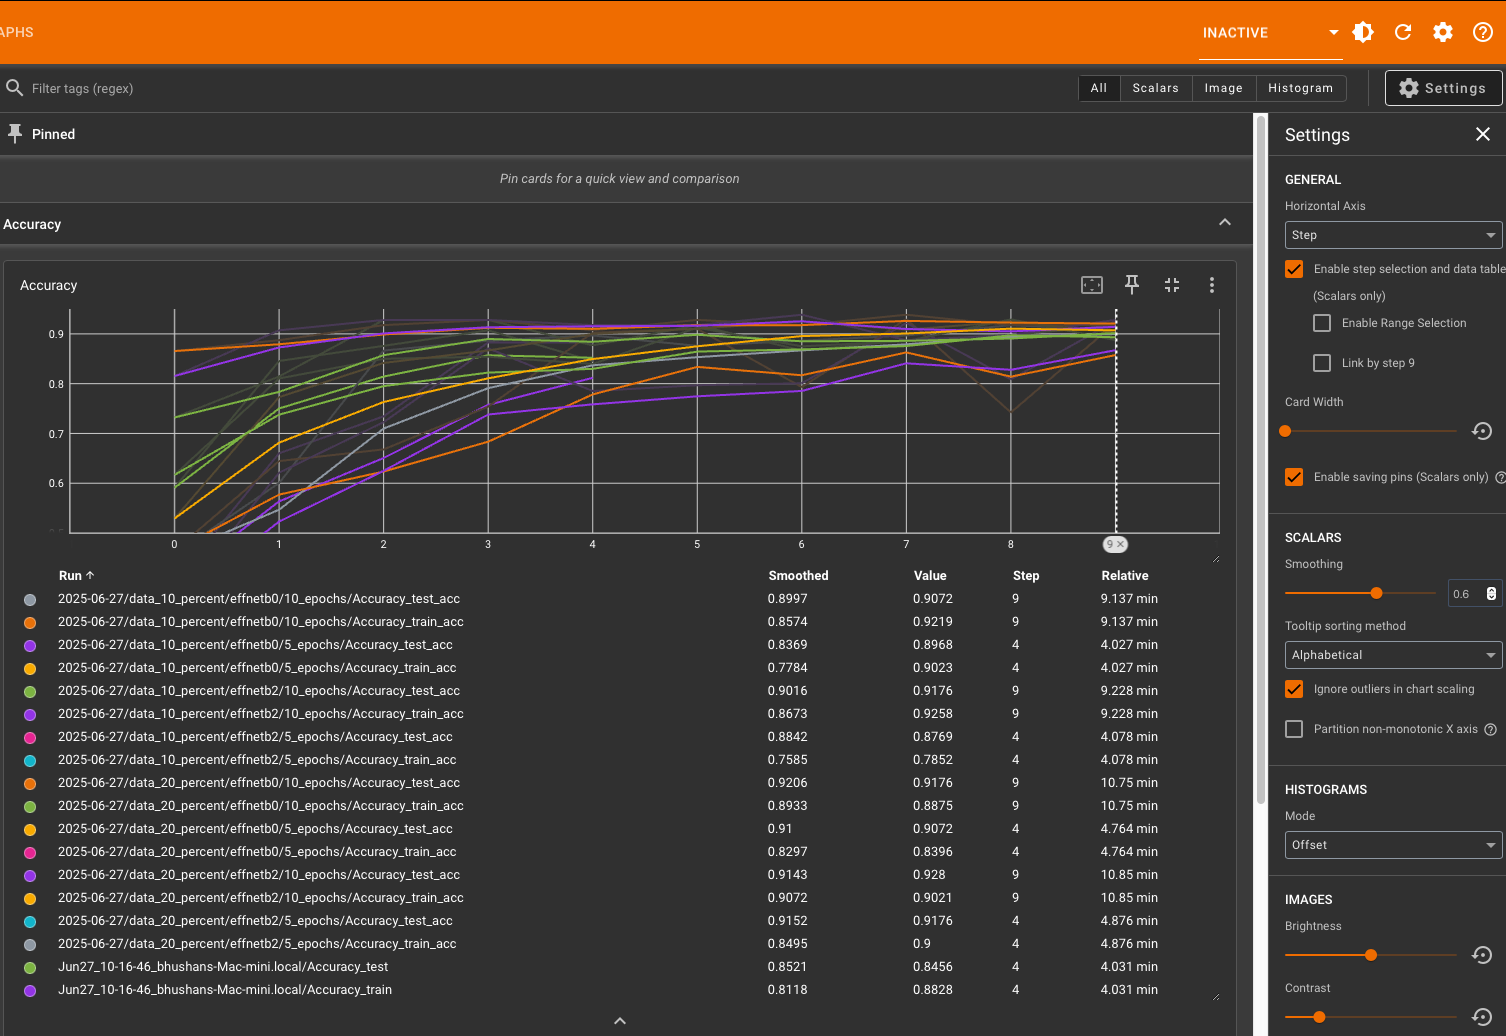
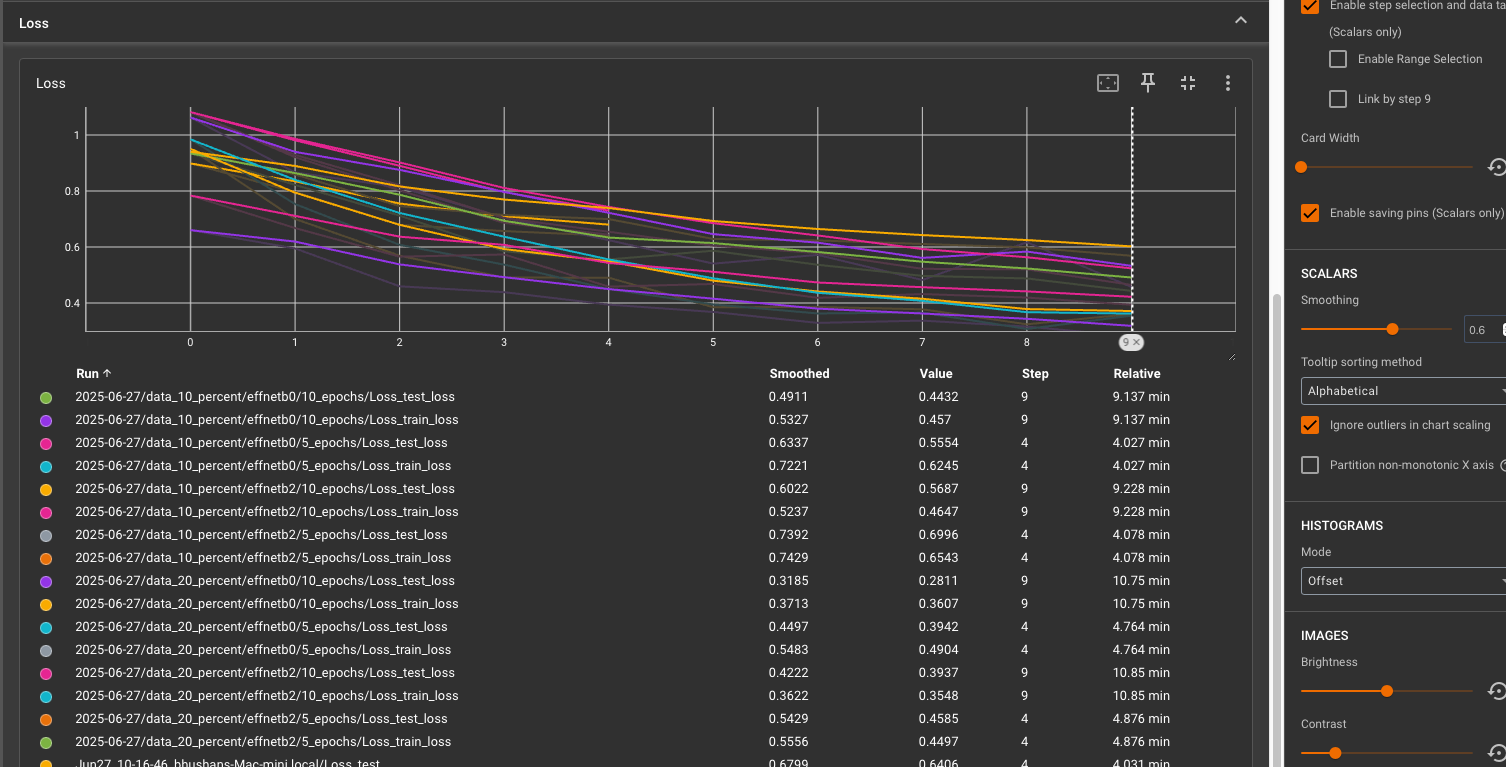

In [46]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [47]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


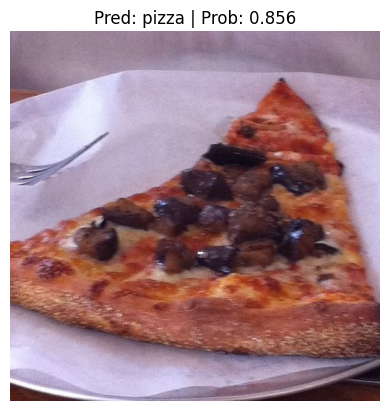

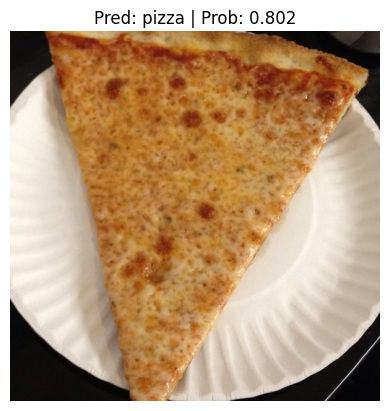

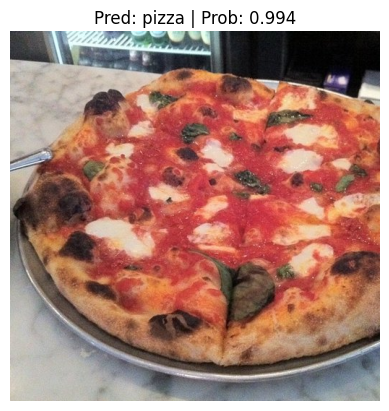

In [49]:
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))